# Project: IBM Model 1

In this project, we implement IBM Model 1 to obtain text alignments in translation tasks.

In [ ]:
from collections import Counter, defaultdict
from itertools import product, permutations
import math
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import string
import tqdm.notebook
import sentencepiece
import torchtext

## IBM Model 1

Here, we implement IBM Model 1 to learn alignment; it iteratively learns word alignments via expectation maximization, with no weight placed on the position of words in the source and target texts. The dataset should be a list of tuples, each tuple containing a pair of words in the source and target language.

In [ ]:
class IBMModel1:
    def __init__(self, data, num_iterations=10, epsilon=1.0, compute_perplexity=True):
        self.data = data
        self.num_iterations = num_iterations
        self.epsilon = epsilon
        self.compute_perplexity = compute_perplexity
        
        # Preprocess the word pairs:
        self.source_words, self.target_words = set(), set()
        for (source,target) in self.data:
            self.source_words.update(source)
            self.target_words.update(target)
        
        # Initialize translation probabilities to the uniform distribution
        self.translation_probs = {(s,t): 1.0/len(self.target_words)
                                  for s,t in product(self.source_words, self.target_words)}
        
    def e_step(self):
        counts = defaultdict(int)
        s_total = defaultdict(int)
        total = defaultdict(int)

        for source, target in self.data:
          for e in target:
            s_total[e] = 0
            for f in source:
              s_total[e] += self.translation_probs[(f, e)]

          for e in target:
            for f in source:
              counts[(f,e)] += self.translation_probs[(f, e)]/s_total[e]
              total[f] += self.translation_probs[(f, e)]/s_total[e]

        return counts, total
        
    def m_step(self, counts, total):
        for f in self.source_words:
          for e in self.target_words:
            self.translation_probs[(f,e)] = counts[(f,e)]/total[f]
        
    def train(self):
        for idx in tqdm.tqdm(range(self.num_iterations)):
            if self.compute_perplexity: 
                print("Iteration: {} | Perplexity: {}".format(idx, self.perplexity()))
            counts, total = self.e_step()
            self.m_step(counts, total)
        if self.compute_perplexity:
            print("Iteration: {} | Perplexity: {}".format(self.num_iterations, self.perplexity()))

    def probability(self, source, target):
        c = self.epsilon/(len(source)**len(target))
        output = []
        for t in target:
          sum = 0
          for s in source:
            sum += self.translation_probs[(s,t)]
          output.append(sum)
        
        output = c*np.prod(output)

        return output

    def perplexity(self):
        log_probs = []
        for source,target in self.data:
          log_probs.append(np.log(self.probability(source,target)))

        perp = np.exp(-1*np.sum(log_probs))

        return perp
        
    def get_alignment(self, source, target):
        output = []

        for i, s in enumerate(source):
          best = 0
          for j, t in enumerate(target):
            if self.translation_probs[(s,t)] > best:
              best = self.translation_probs[(s,t)]
              best_idx = j
          output.append((i, best_idx))

        return output

In [ ]:
ibm = IBMModel1(aligned_data)
ibm.train()

In [ ]:
assert(ibm.get_alignment(["ein", "buch"], ["a", "book"]) == [(0, 0), (1, 1)])
with open("example_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

## Visualization of Alignments

As an example, we can visualize the alignments obtained on a toy dataset.

In [ ]:
def visualize_alignment(alignment, source, target, save=None):
    source_words = source
    target_words = target
    word_dict = {(i,j):(source_words[i], target_words[j]) for i,j in product(range(len(source)), range(len(target)))}
    G = nx.Graph()
    G.add_nodes_from(source_words, bipartite=0)
    G.add_nodes_from(target_words, bipartite=1)
    G.add_edges_from([word_dict[a] for a in alignment])

    pos = {n:(0,-i) for i, n in enumerate(source_words)}
    pos.update(((n, (1,-i)) for i, n in enumerate(target_words)))
    plt.figure(figsize=(10,6))
    nx.draw_networkx(G, pos=pos, node_color='none', width=2, font_size=14)

    if save:
      plt.savefig(save, bbox_inches='tight')

    plt.show()

In [ ]:
aligned_data = [
    (['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small']),
    (['das', 'haus', 'ist', 'ja', 'groß'], ['the', 'house', 'is', 'big']),
    (['das', 'buch', 'ist', 'ja', 'klein'], ['the', 'book', 'is', 'small']),
    (['das', 'haus'], ['the', 'house']),
    (['das', 'buch'], ['the', 'book']),
    (['ein', 'buch'], ['a', 'book'])
]
ibm_small = IBMModel1(aligned_data, num_iterations = 10)
ibm_small.train()

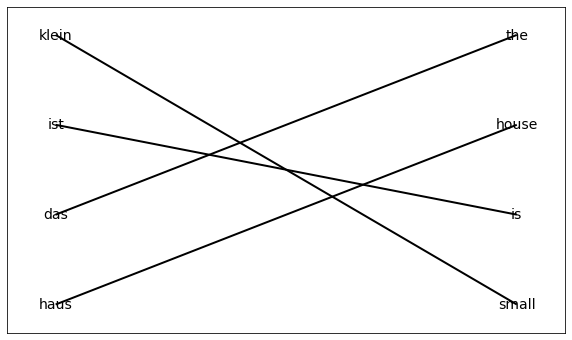

In [ ]:
alignment = ibm_small.get_alignment(['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small'])
visualize_alignment(alignment, ['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small'])

As an example, we apply the model to the Multi30K dataset for German and English.

In [ ]:
extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root=".")

In [ ]:
def preprocess(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    sentence = sentence.strip().lower().split()
    return sentence

aligned_data = []
for example in training_data[:1000]:
    source = preprocess(example.src)
    target = preprocess(example.trg)
    aligned_data.append((source, target))

ibm = IBMModel1(aligned_data, compute_perplexity=False)
ibm.train()

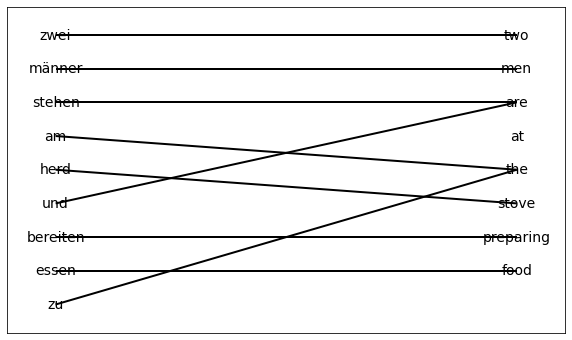

In [ ]:
for example in training_data[4:5]:
    source = preprocess(example.src)
    target = preprocess(example.trg)
    alignment = ibm.get_alignment(source, target)
    visualize_alignment(alignment, source, target, save='success.pdf')